## Accuracy-Resource profiler
### dataset (3 mins per date)
- 20180517
- 20180621
- 20180816

### algo (obsolete)
#### univmon
- cardinality
- entropy
- hh

#### hll
- cardinality

#### CM
- hh
- entropy

#### CS
- hh

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import json

---

## Define common functions

In [3]:
## read_data from result of control plane
def read_data(algos, row=4, width=1024, level=1, seed=1, count=1, flowkey='dstIP,dstPort', 
              epochs=['10', '20', '30'], dataset='equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/'):
    res = {}
    for algo in algos:
        res[algo] = []
        for epoch in epochs:
            path = f"../../result_cp/QuerySketch/{algo}/{dataset}"\
                    f"{flowkey}/row_{row}_width_{width}_level_{level}_epoch_{epoch}_count_{count}_seed_{seed}/data.pkl"
            # print(algo, epoch)
            with open(path, 'rb') as f:
                ll = pickle.load(f)
            res[algo].append(ll)
            # print(ll[0])
    return res

In [4]:
### Temporary useless

# ## Define metric -> algos
# def get_metrics_algos():
#     metrics_algos = {}
#     metrics_algos['hh'] = ['cm', 'cs']
#     metrics_algos['card'] = ['hll', 'lc']
#     metrics_algos['entropy'] = ['cm']
#     metrics_algos['fsd'] = ['mrac']
#     return metrics_algos
# metrics_algos = get_metrics_algos()

# ## Define algos -> metric
# def get_algos_metrics():
#     tmp = get_metrics_algos()
#     algos_metrics = {}
#     for m in tmp:
#         for algo in tmp[m]:
#             if algo not in algos_metrics:
#                 algos_metrics[algo] = [m]
#             else:
#                 algos_metrics[algo].append(m)
#     return algos_metrics
# algos_metrics = get_algos_metrics()

# general_metrics = ['univmon']

In [5]:
## Define mapping dictionary for index <---> metric
algos = ['univmon', 'cm', 'cs', 'hll', 'lc', 'mrac', 'll', 'mrb']
def get_metric_mapping(algos = ['univmon', 'cm', 'cs', 'hll']):
    mapping = {}
    for k in algos:
        mapping[k] = {}

    if 'univmon' in algos:
        # UNIV: [true_entropy, sim_entropy, sim_entropy_error, true_card, sim_card, sim_card_error, ARE]
        mapping['univmon']['hh'] = 6
        mapping['univmon']['card'] = 5 
        mapping['univmon']['entropy'] = 2
    if 'cm' in algos:
        # cm: [entropy, entropy_est, relative_entropy_error, sim_ARE_error, sim_change_detection_error, WMRD]
        mapping['cm']['hh'] = 3
        mapping['cm']['entropy'] = 2
        mapping['cm']['change_det'] = 4
        mapping['cm']['fsd'] = 5
    if 'cs' in algos:
        # cs: [entropy, entropy_est, relative_entropy_error, sim_ARE_error, sim_change_detection_error, WMRD]
        mapping['cs']['hh'] = 3
        mapping['cs']['entropy'] = 2
        mapping['cs']['change_det'] = 4
        mapping['cs']['fsd'] = 5
    if 'hll' in algos:
        # hll: [true_cardinality, sim_cardinality, sim_error]
        mapping['hll']['card'] = 2
    if 'll' in algos:
        # ll: [true_cardinality, sim_cardinality, sim_error]
        mapping['ll']['card'] = 2
    if 'lc' in algos:
        # lc: [true_cardinality, sim_cardinality, sim_error]
        mapping['lc']['card'] = 2
    if 'mrac' in algos:
        # mrac: [WMRD, entropy_true, entropy_est, entropy_err]
        mapping['mrac']['fsd'] = 0
        mapping['mrac']['entropy'] = 3
    if 'mrb' in algos:
        # mrb: [true_cardinality, sim_cardinality, sim_error]
        mapping['mrb']['card'] = 2
    return mapping
mapping = get_metric_mapping(algos)

---

## Define profiling functions

In [6]:
# # get_data_from_pkl
# # combine the flowkeys, datasets, epochs to a list
# def get_result_from_pkl(algos = ['cm'], rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072], level=1, seed=1, 
#                            count=1, measure_list = ['hh', 'entropy'], flowkeys = ["dstIP,dstPort",], epochs = ['30'],
#                      datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/']):
#     # key: metric, row, width
#     ret = {}
#     for m in measure_list:
#         ret[m] = {}
#         for r in rows:
#             ret[m][r] = {}
#             for w in widths:
#                 ret[m][r][w] = []

#     for r in rows:
#         for w in widths:
#             for flowkey in flowkeys:
#                 for dataset in datasets:
#                     tmp = read_data(algos, r, w, level, seed, count, flowkey, epochs, dataset)
#                     for algo in algos:
#                         for measure in measure_list:
#                             # epoch
#                             for e in range(len(epochs)):
#                                 # ll = []
#                                 # raw data
#                                 for d in tmp[algo][e]:
#                                     # ll.append(d[mapping[algo][measure]])
#                                     ret[measure][r][w].append(d[mapping[algo][measure]])
#                                 # print(w, flowkey, measure, epochs[e], np.mean(ll))
#     return ret

# # # key: metric, row, width
# # ret = get_result_from_pkl()
# # print(ret['hh'][1][4096])

In [7]:
# get_data_from_pkl
# combine the flowkeys, datasets, epochs to a list
def get_result_from_pkl(algos = ['cm'], rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072], level=1, seeds=[1, 2, 3], 
                           count=1, measure_list = ['hh', 'entropy'], flowkeys = ["dstIP,dstPort",], epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/']):
    # key: seed, metric, row, width
    total_ret = {}
    for seed in seeds:
        total_ret[seed] = {}
        for m in measure_list:
            total_ret[seed][m] = {}
            for r in rows:
                total_ret[seed][m][r] = {}
                for w in widths:
                    total_ret[seed][m][r][w] = []
    # get results from all seeds
    for seed in seeds:
        for r in rows:
            for w in widths:
                for flowkey in flowkeys:
                    for dataset in datasets:
                        tmp = read_data(algos, r, w, level, seed, count, flowkey, epochs, dataset)
                        for algo in algos:
                            for measure in measure_list:
                                # epoch
                                for e in range(len(epochs)):
                                    # raw data
                                    for d in tmp[algo][e]:
                                        # ret[measure][r][w].append(d[mapping[algo][measure]])
                                        total_ret[seed][measure][r][w].append(d[mapping[algo][measure]])
                                    # print(w, flowkey, measure, epochs[e], np.mean(ll))
    # print(total_ret)
    # get mean/median from all seed results
    # key: metric, row, width
    final_ret = {}                                
    for m in measure_list:
        final_ret[m] = {}
        for r in rows:
            final_ret[m][r] = {}
            for w in widths:
                final_ret[m][r][w] = []
    
    for m in measure_list:
        for r in rows:
            for w in widths:
                arr = None
                for seed in seeds:
                    if arr is None:
                        arr = total_ret[seed][m][r][w]
                    else:
                        arr = np.vstack([arr, total_ret[seed][m][r][w]])
                # get mean value from all seeds
                final_ret[m][r][w] = np.mean(arr, axis=0).tolist()
                # print(f'm: {m} r: {r} w: {w}, {final_ret[m][r][w]}')
    # print(len(final_ret[m][r][w]))
    return final_ret

# # key: metric, row, width
# ret = get_result_from_pkl()
# print(ret['hh'][1][4096])

In [8]:
def get_counter_size(algo = 'cm'):
    counter_size = 4
    if algo == 'hll' or algo == 'll':
        # int8
        counter_size = 1
    elif algo == 'lc' or algo == 'mrb':
        # 1 bit
        counter_size = 1/8
    return counter_size

# The original width is the number of counter, so it needs to multiply the size of the counter
def convert_width_to_real_byte(algo = 'cm', widths = [4096, 8192, 16384, 32768, 65536, 131072]):
    np_arr = np.array(widths)
    counter_size = get_counter_size(algo)
    return (np_arr * counter_size).astype(np.int32).tolist()

In [9]:
def dump_json(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384], level=1, measure_list = ['hh', 'entropy'], isDumpJson=False):
    counter_size = get_counter_size(algo)
    # key: metric, row, width
    ret = {}
    for m in measure_list:
        ret[m] = {}
        for r in rows:
            ret[m][r] = {}
            for w in widths:
                ret[m][r][w] = data[m][r][int(w/counter_size)]
    
    if isDumpJson:
        # with open(f'results/num_of_pcaps/pcap_3/{algo}_level_{level}_result.json', 'w') as f:
        # with open(f'results/profiler_diff_dataset/{algo}_level_{level}_result.json', 'w') as f:
        with open(f'results/profiler_origin/{algo}_level_{level}_result.json', 'w') as f:
            json.dump(ret, f)
    
    return ret

In [10]:
# get mean value for all list in the same row size & col size & metric
def get_mean_value(ret, rows = [1, 2, 3, 4, 5], measure_list = ['hh', 'entropy']):
    # key: metric, row
    # mean value of the same column 
    data = {}
    for m in measure_list:
        data[m] = {}
        for r in rows:
            data[m][r] = []
            for w in ret[m][r]:
                data[m][r].append(np.mean(ret[m][r][w]))
    return data

# mean_data = get_mean_value(ret)
# mean_data['entropy']

In [11]:
# plot profiling result (mean value) for all metrics with different rows
def plot_result(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
               level = 1, measure_list = ['hh', 'entropy'], isSaveFig=False, isShowByte=False):
    x_labels = []
    if isShowByte:
        for w in widths:
            x_labels.append(str(w))
    else:
        for w in widths:
            x_labels.append(str(int(w / 1024)))

    for m in measure_list:
        fig = plt.figure(figsize = (7, 5))

        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])

        # Creating plot
        for r in rows:
            bp = ax.plot(widths, data[m][r], label=f'row: {r}')

        # plt.axvline(x = 8192, color = 'darkgreen', linestyle='--')

        ax.set_xticks(widths)
        if isShowByte:
            ax.set_xticklabels(x_labels, fontsize=14, rotation = 45)
            plt.xlabel("Width (BYTE)", fontsize=16)
        else:
            ax.set_xticklabels(x_labels, fontsize=14)
            plt.xlabel("Width (KB)", fontsize=16)
            
        plt.yticks(fontsize=14)
            
        title_str = ''
        ylabel_str = ''
        ylabel_fontsize = 16
        if m == 'hh':
            title_str = f'{algo.upper()}: Heavy Hitter'
            ylabel_str = "Average Relative Error (%)"
        elif m == 'entropy':
            title_str = f'{algo.upper()}: Entropy'
            ylabel_str = "Relative Error (%)"
        elif m == 'card':
            title_str = f'{algo.upper()}: Cardinality'
            ylabel_str = "Relative Error (%)"
        elif m == 'fsd':
            title_str = f'{algo.upper()}: Flow Size Distribution'
            ylabel_str = "Weighted Mean Relative Difference (WMRD)"
            ylabel_fontsize = 14
        elif m == 'change_det':
            title_str = f'{algo.upper()}: Change Detection'
            ylabel_str = "Average Relative Error (%)"

        if level > 1:
            title_str += f', Level: {level}'
        plt.title(title_str, fontsize=18)
        plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

        # legend_patch = []
        # legend_patch.append(mpatches.Patch(color='crimson', label='Best algorithms'))
        # legend_patch.append(mpatches.Patch(color='royalblue', label='General algorithm'))
        # plt.legend(handles=legend_patch, fontsize=16)
        plt.legend(fontsize=16)
        
        if isSaveFig:
            plt.savefig(f'figures/profiler/{algo.upper()}_{m}_profiling.png', format='png', bbox_inches='tight')
            # plt.savefig(f'figures/{algo.upper()}_{m}_profiling.eps', format='eps', bbox_inches='tight')
        
        # show plot
        plt.show()
        
# plot_result(mean_data)

In [12]:
# plot profiling result (mean value) for all metrics with different rows
def plot_result_for_overleaf(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
               level = 1, measure_list = ['hh', 'entropy'], isSaveFig=False, isShowByte=False):
    x_labels = []
    if isShowByte:
        for w in widths:
            x_labels.append(str(w))
    else:
        for w in widths:
            x_labels.append(str(int(w / 1024)))
            
    marker_list = ["o", "s", "^", "x", 'p']

    for m in measure_list:
        fig = plt.figure(figsize = (10, 6))

        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])

        # Creating plot
        for i, r in enumerate(rows):
            bp = ax.plot(widths, data[m][r], label=f'Number of rows: {r}',
                        linewidth='2', marker=marker_list[i])

        # plt.axvline(x = 8192, color = 'darkgreen', linestyle='--')

        ax.set_xticks(widths)
        if isShowByte:
            ax.set_xticklabels(x_labels, fontsize=20, rotation = 45)
            plt.xlabel("Width (BYTE)", fontsize=30)
        else:
            ax.set_xticklabels(x_labels, fontsize=20)
            plt.xlabel("Width of each row (KB)", fontsize=28)
            
        plt.yticks(fontsize=26)    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
            
        title_str = ''
        ylabel_str = ''
        ylabel_fontsize = 28
        if m == 'hh':
            title_str = f'{algo.upper()}: Heavy Hitter'
            ylabel_str = "Average Relative Error (%)"
        elif m == 'entropy':
            title_str = f'{algo.upper()}: Entropy'
            ylabel_str = "Relative Error (%)"
        elif m == 'card':
            title_str = f'{algo.upper()}: Cardinality'
            ylabel_str = "Relative Error (%)"
        elif m == 'fsd':
            title_str = f'{algo.upper()}: Flow Size Distribution'
            ylabel_str = "Weighted Mean Relative Difference (WMRD)"
            ylabel_fontsize = 14
        elif m == 'change_det':
            title_str = f'{algo.upper()}: Change Detection'
            ylabel_str = "Average Relative Error (%)"

        if level > 1:
            title_str += f', Level: {level}'
        # plt.title(title_str, fontsize=18)
        plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

        # legend_patch = []
        # legend_patch.append(mpatches.Patch(color='crimson', label='Best algorithms'))
        # legend_patch.append(mpatches.Patch(color='royalblue', label='General algorithm'))
        # plt.legend(handles=legend_patch, fontsize=16)
        plt.legend(fontsize=22, frameon=False)
        
        if isSaveFig:
            plt.savefig(f'figures/profiler/overleaf/{algo.upper()}_{m}_profiling.pdf', format='pdf', bbox_inches='tight')
        
        # show plot
        plt.show()
        
# plot_result(mean_data)

In [13]:
# plot profiling result (mean value) for all metrics with different rows
def boxplot_result(data, algo = 'cm', rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072],
               level = 1, measure_list = ['hh', 'entropy'], isSaveFig=False, isShowByte=False):
    # key of `data`: metric, row, width
    x_labels = []
    if isShowByte:
        for w in widths:
            x_labels.append(str(w))
    else:
        for w in widths:
            x_labels.append(str(int(w / 1024)))

    for m in measure_list:
        for r in rows:
            plot_list = []
            for w in widths:
                plot_list.append(data[m][r][w])
            
            fig = plt.figure(figsize = (10, 6))

            # Creating axes instance
            ax = fig.add_axes([0, 0, 1, 1])

            # Creating plot
            # bplot = ax.boxplot(x=plot_list, 
            #                    positions = [1.2,1.8, 3.2,3.8, 5.2,5.8],
            #                    patch_artist=True)
            bplot = ax.boxplot(x=plot_list, labels=widths)

#             ax.set_xticks([0] + widths)
            if isShowByte:
                ax.set_xticklabels(x_labels, fontsize=14, rotation = 45)
                plt.xlabel("Width (BYTE)", fontsize=16)
            else:
                ax.set_xticklabels(x_labels, fontsize=14)
                plt.xlabel("Width (KB)", fontsize=16)

            plt.yticks(fontsize=14)

            title_str = ''
            ylabel_str = ''
            ylabel_fontsize = 16
            if m == 'hh':
                title_str = f'{algo.upper()}: Heavy Hitter, Row: {r}'
                ylabel_str = "Average Relative Error (%)"
            elif m == 'entropy':
                title_str = f'{algo.upper()}: Entropy, Row: {r}'
                ylabel_str = "Relative Error (%)"
            elif m == 'card':
                title_str = f'{algo.upper()}: Cardinality, Row: {r}'
                ylabel_str = "Relative Error (%)"
            elif m == 'fsd':
                title_str = f'{algo.upper()}: Flow Size Distribution, Row: {r}'
                ylabel_str = "Weighted Mean Relative Difference (WMRD)"
                ylabel_fontsize = 14
            elif m == 'change_det':
                title_str = f'{algo.upper()}: Change Detection, Row: {r}'
                ylabel_str = "Average Relative Error (%)"
            
            if level > 1:
                title_str += f', Level: {level}'
            plt.title(title_str, fontsize=18)
            plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

            # plt.legend(fontsize=16)

            if isSaveFig:
                plt.savefig(f'figures/profiler/{algo.upper()}_{m}_row_{r}_boxplot.png', format='png', bbox_inches='tight')
                # plt.savefig(f'figures/{algo.upper()}_{m}_row_{r}_boxplot.eps', format='eps', bbox_inches='tight')

            # show plot
            plt.show()

In [14]:
def profiling_analysis(algos = ['cm'], rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072], level=1, seeds=[1, 2, 3], 
                           count=1, measure_list = ['hh', 'entropy'], flowkeys = ["srcIP,srcPort", "dstIP,dstPort",], epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/'],
                     isSaveFig=False, isDumpJson=False, isBoxPlot=False, isShowByte=False): 
    
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    widths = convert_width_to_real_byte(algos[0], widths)
    byte_ret = dump_json(ret, algos[0], rows, widths, level, measure_list, isDumpJson)
    mean_ret = get_mean_value(ret, rows, measure_list)
    plot_result(mean_ret, algos[0], rows, widths, level, measure_list, isSaveFig, isShowByte)
    # plot_result_for_overleaf(mean_ret, algos[0], rows, widths, level, measure_list, isSaveFig, isShowByte)
    if isBoxPlot:
        boxplot_result(byte_ret, algos[0], rows, widths, level, measure_list, isSaveFig, isShowByte)
    # return ret
    
    # print('----------------------------')
    # print(f'Complete {algos[0]} profiling')
    # print('----------------------------')

In [15]:
# tmp = profiling_analysis(['hll'], [1], [4096, 8192, 16384, 32768, 65536], 1, 3, 1, ['card'])
# tmp['hh'][1][16384]

#### Common variables

In [16]:
## Hyperparameters
isSaveFig = False
isDumpJson = True
# seeds = [1, 2, 3, 4, 5]
seeds = [1, 2, 3]

# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]

datasets = ['equinix-nyc.dirA.20180816-130100.UTC.anon.pcap/', 
            'equinix-nyc.dirA.20180816-130500.UTC.anon.pcap/',
            'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/',
            'equinix-nyc.dirA.20180816-133000.UTC.anon.pcap/',
            'equinix-nyc.dirA.20180816-140000.UTC.anon.pcap/']

# ## diff dataset
# datasets = ['equinix-nyc.dirA.20181018-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20181018-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20181018-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20181115-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20181115-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20181115-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20181220-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20181220-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20181220-131100.UTC.anon.pcap/', ]


---

## Measure CM

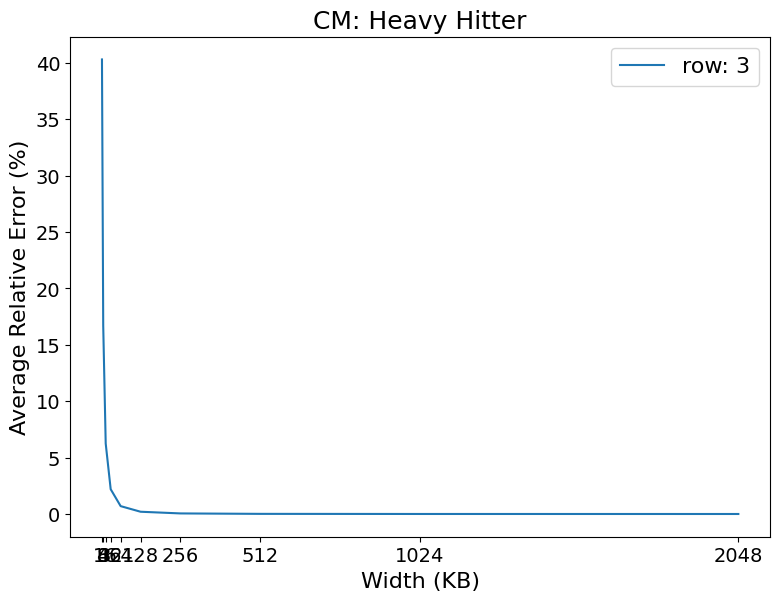

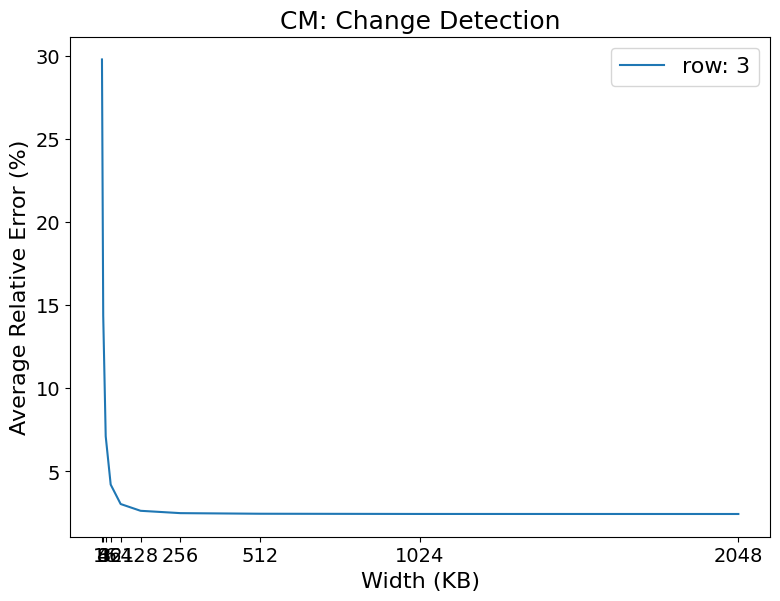

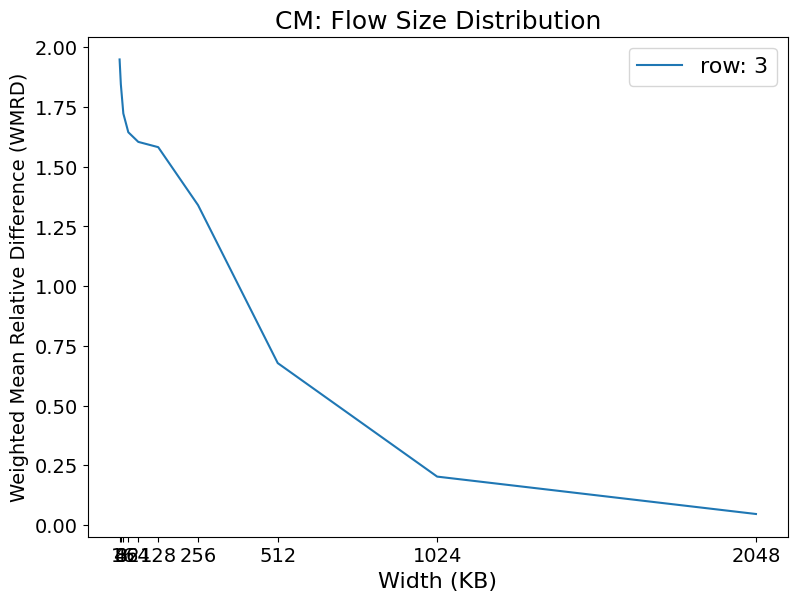

In [30]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['cm']
# rows = [1, 2, 3, 4, 5]
rows = [3]

# widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
# widths = [4096, 8192, 16384, 32768, 65536, 131072]
widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
level = 1
count = 1
measure_list = ['hh', 'change_det', 'fsd'] # , 'entropy'
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP"]
epochs = ['30']
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte)

---

## Measure CS

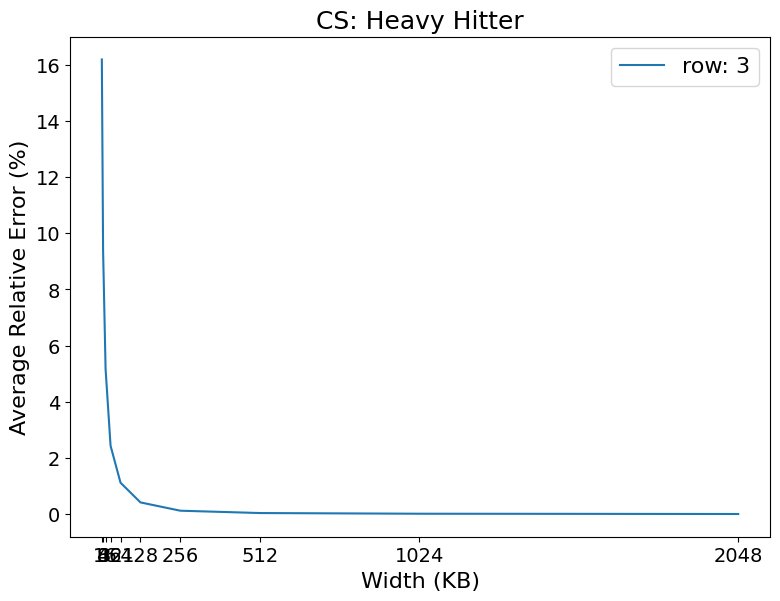

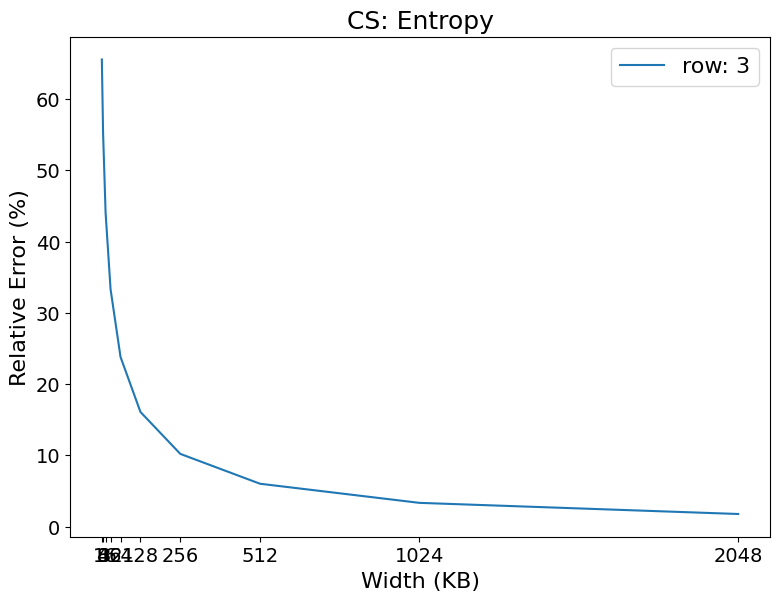

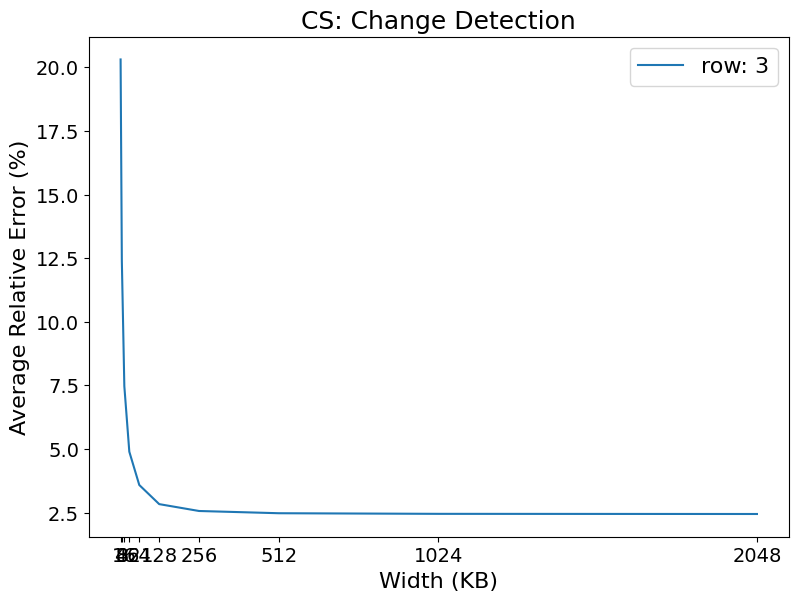

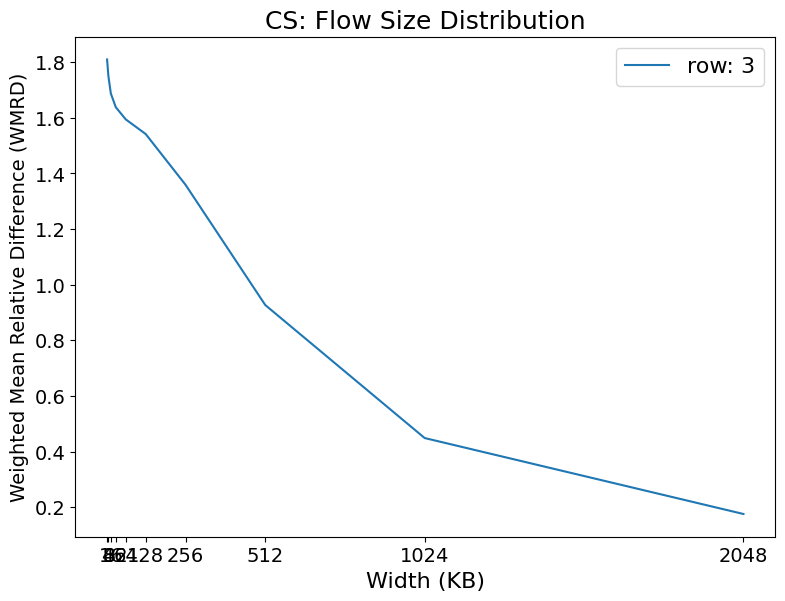

In [31]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['cs']
# rows = [1, 2, 3, 4, 5]
rows = [3]
# widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
# widths = [4096, 8192, 16384, 32768, 65536, 131072]
widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
level = 1
count = 1
measure_list = ['hh', 'entropy', 'change_det', 'fsd']
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP"]
epochs = ['30']
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte)

---

## Measure UnivMon

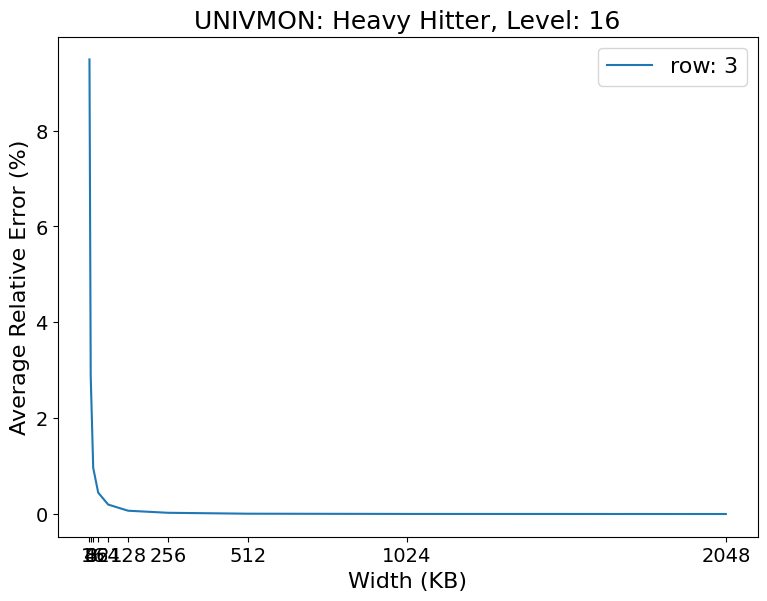

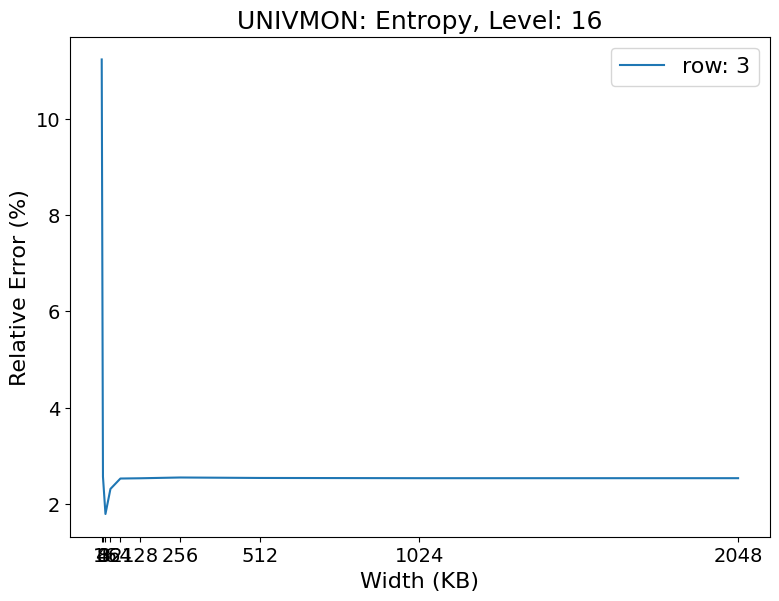

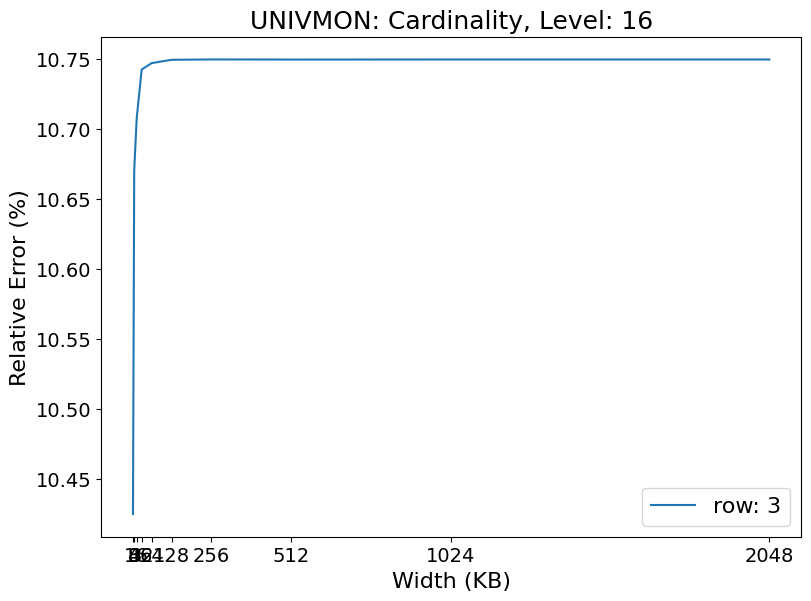

In [32]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['univmon']
# rows = [3, 4, 5]
rows = [3]
# widths = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
# widths = [256, 512, 1024, 2048, 4096, 8192]
widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
level = 16
count = 1
measure_list = ['hh', 'entropy', 'card']
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte)

---

## Measure LC

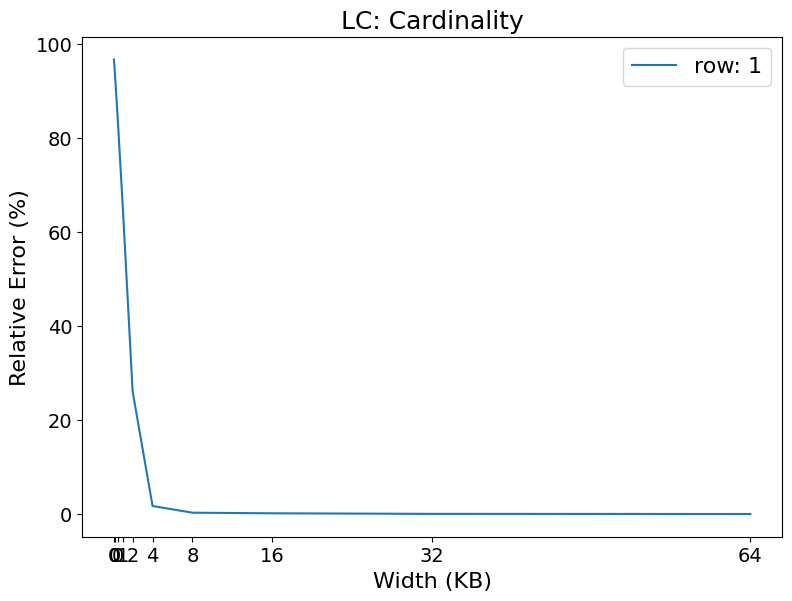

In [33]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['lc']
rows = [1]
# widths = [32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304]
# widths = [131072, 262144, 524288, 1048576, 2097152, 4194304]
widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
level = 1
count = 1
measure_list = ['card']
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte)

---

## Measure HLL

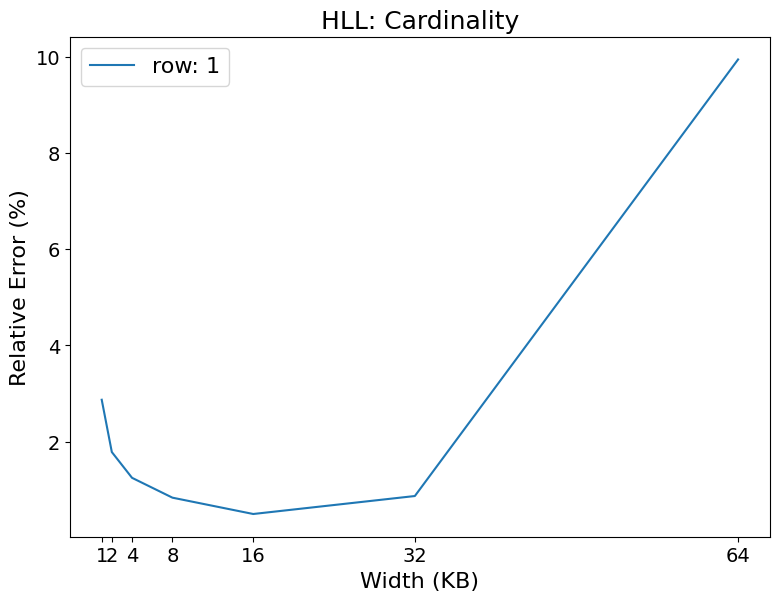

In [34]:
algos = ['hll']
rows = [1]
# widths = [2048, 4096, 8192, 16384, 32768, 65536]
# widths = [16384, 32768, 65536]
widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536]
level = 1
count = 1
measure_list = ['card']
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte)

---

## Measure LL

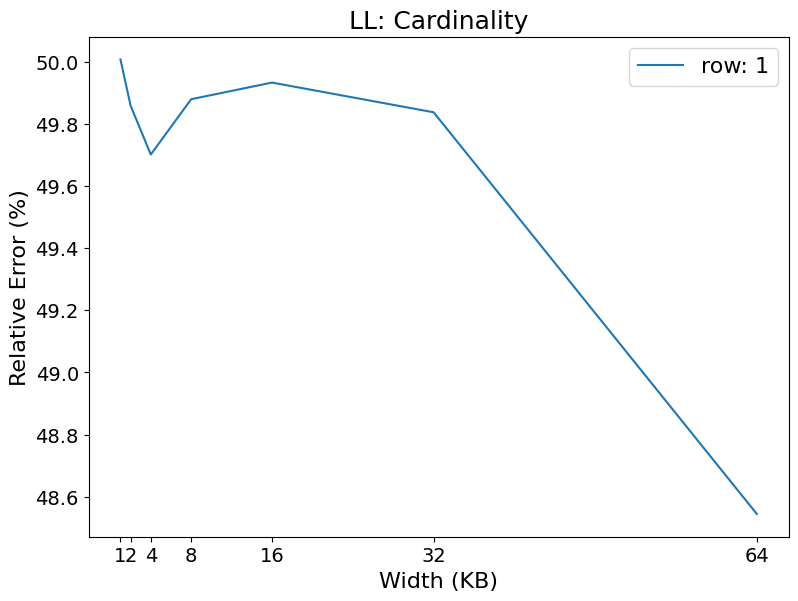

In [35]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['ll']
rows = [1]
# widths = [4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
# widths = [16384, 32768, 65536, 131072, 262144, 524288]
widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536]
level = 1
count = 1
measure_list = ['card']
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte)

---

## Measure MRAC

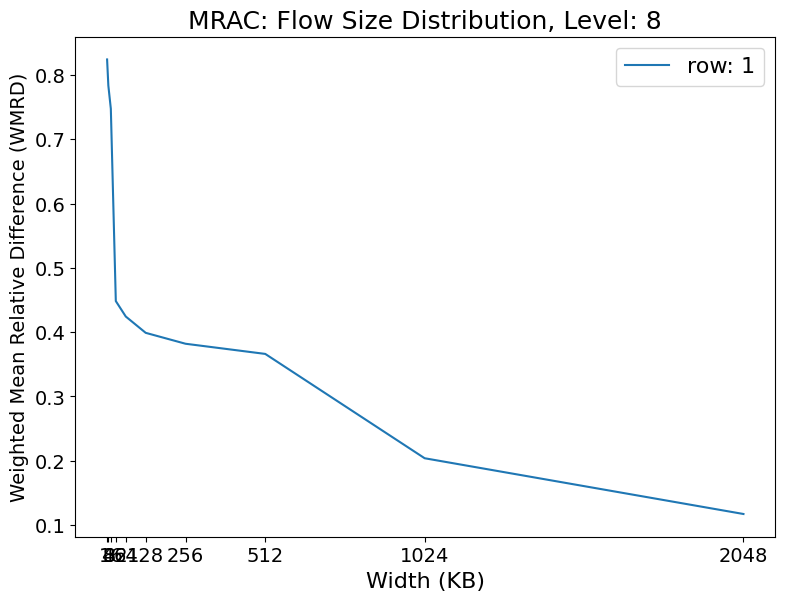

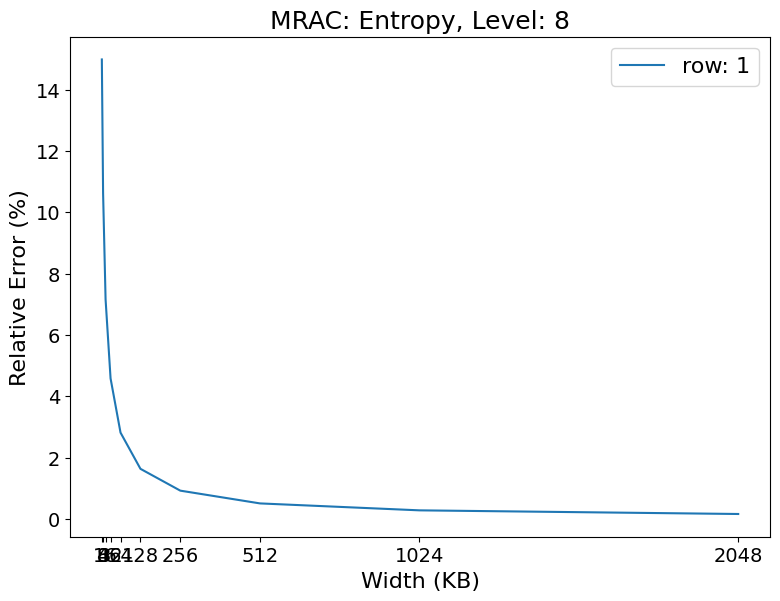

In [37]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['mrac']
rows = [1]
# widths = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
# widths = [512, 1024, 2048, 4096, 8192, 16384]
widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
level = 8
count = 1
# measure_list = ['fsd'] #, 'entropy'
measure_list = ['fsd', 'entropy']
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]
# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte)

---

## Measure MRB

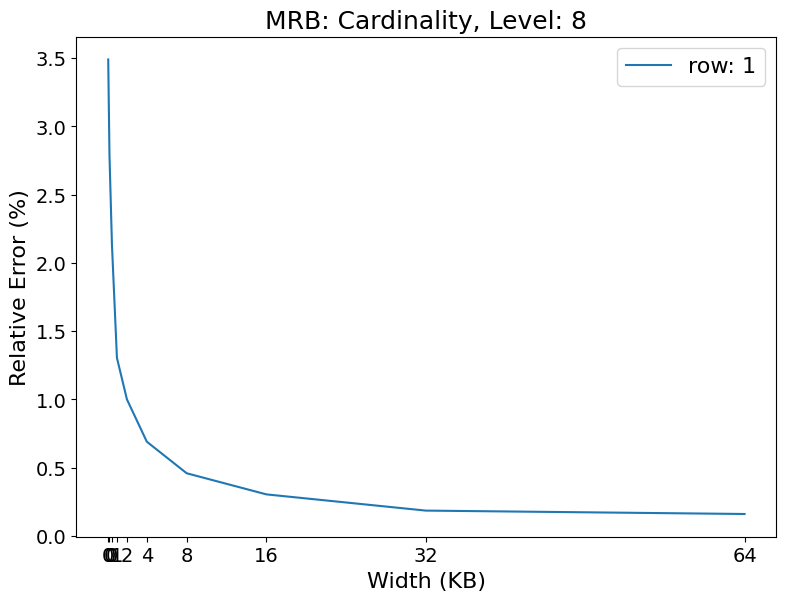

In [38]:
# date_list = [20180517, 20180621, 20180816]
# width_list = [4096, 8192, 16384, 32768, 65536, 131072]
# pcap_count = 3
algos = ['mrb']
rows = [1]
# widths = [4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
# widths = [16384, 32768, 65536, 131072, 262144, 524288]
widths = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
level = 8
count = 1
measure_list = ['card']
# flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']
# datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
#            'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]

# isSaveFig = False
# isDumpJson = False
isBoxPlot = False
isShowByte = False

profiling_analysis(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets, isSaveFig, isDumpJson, isBoxPlot, isShowByte)

---

## Verify actual row feature in C++ simulator

In [23]:
## read_data from result of control plane
def read_data_with_count(algos, row=4, width=1024, flowkey='dstIP,dstPort', epochs=['10', '20', '30'], dataset='equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/'):
    res = {}
    for algo in algos:
        res[algo] = []
        for epoch in epochs:
            path = f"../../result_cp/QuerySketch/{algo}/{dataset}"\
                    f"{flowkey}/row_{row}_width_{width}_epoch_{epoch}_count_1/data.pkl"
            # print(algo, epoch)
            print(path)
            with open(path, 'rb') as f:
                ll = pickle.load(f)
            res[algo].append(ll)
            # print(ll[0])
    return res

def read_data_without_count(algos, row=4, width=1024, flowkey='dstIP,dstPort', epochs=['10', '20', '30'], dataset='equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/'):
    res = {}
    for algo in algos:
        res[algo] = []
        for epoch in epochs:
            path = f"../../result_cp/QuerySketch/{algo}/{dataset}"\
                    f"{flowkey}/row_{row}_width_{width}_epoch_{epoch}/data.pkl"
            # print(algo, epoch)
            print(path)
            with open(path, 'rb') as f:
                ll = pickle.load(f)
            res[algo].append(ll)
            # print(ll[0])
    return res

In [24]:
algos = ['cm']
r = 5
widths = [4096, 8192]
flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
epochs = ['30']

for w in widths:
    for flowkey in flowkeys:
        tmp = read_data_with_count(algos, r, w, flowkey, epochs)
        ll = []
        for e in range(1):
            for d in tmp['cm'][e]:
                ll.append(d[mapping['cm']['entropy']])
            print(w, flowkey, e, np.mean(ll))
print('=======')
r = 3
widths = [4096, 8192]

for w in widths:
    for flowkey in flowkeys:
        tmp = read_data_with_count(algos, r, w, flowkey, epochs)
        ll = []
        for e in range(1):
            for d in tmp['cm'][e]:
                ll.append(d[mapping['cm']['entropy']])
            print(w, flowkey, e, np.mean(ll))
print('=======')        
r = 1
widths = [4096, 8192]

for w in widths:
    for flowkey in flowkeys:
        tmp = read_data_with_count(algos, r, w, flowkey, epochs)
        ll = []
        for e in range(1):
            for d in tmp['cm'][e]:
                ll.append(d[mapping['cm']['entropy']])
            print(w, flowkey, e, np.mean(ll))

../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/srcIP,srcPort/row_5_width_4096_epoch_30_count_1/data.pkl
4096 srcIP,srcPort 0 3.8756532133726687
../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/dstIP,dstPort/row_5_width_4096_epoch_30_count_1/data.pkl
4096 dstIP,dstPort 0 11.109884582587494
../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/srcIP,srcPort/row_5_width_8192_epoch_30_count_1/data.pkl
8192 srcIP,srcPort 0 14.009422084826472
../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/dstIP,dstPort/row_5_width_8192_epoch_30_count_1/data.pkl
8192 dstIP,dstPort 0 19.341230019774684
../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/srcIP,srcPort/row_3_width_4096_epoch_30_count_1/data.pkl
4096 srcIP,srcPort 0 3.8921099043658205
../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/dstIP,dstPort/row_3_width_4096_epoch_30_count_1

In [25]:
algos = ['cm']
r = 4
widths = [4096, 8192]
flowkeys = ["srcIP,srcPort", "dstIP,dstPort",]
epochs = ['30']

for w in widths:
    for flowkey in flowkeys:
        tmp = read_data_without_count(algos, r, w, flowkey, epochs)
        ll = []
        for e in range(1):
            for d in tmp['cm'][e]:
                ll.append(d[mapping['cm']['entropy']])
            print(w, flowkey, e, np.mean(ll))

../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/srcIP,srcPort/row_4_width_4096_epoch_30/data.pkl
4096 srcIP,srcPort 0 3.883881558869245
../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/dstIP,dstPort/row_4_width_4096_epoch_30/data.pkl
4096 dstIP,dstPort 0 11.117881431646463
../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/srcIP,srcPort/row_4_width_8192_epoch_30/data.pkl
8192 srcIP,srcPort 0 14.017649483183927
../../result_cp/QuerySketch/cm/equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/dstIP,dstPort/row_4_width_8192_epoch_30/data.pkl
8192 dstIP,dstPort 0 19.349330922513275
